# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [76]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [77]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [78]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [79]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: потому что он возвращает вероятности принадлежности к классу,а не классы

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [80]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


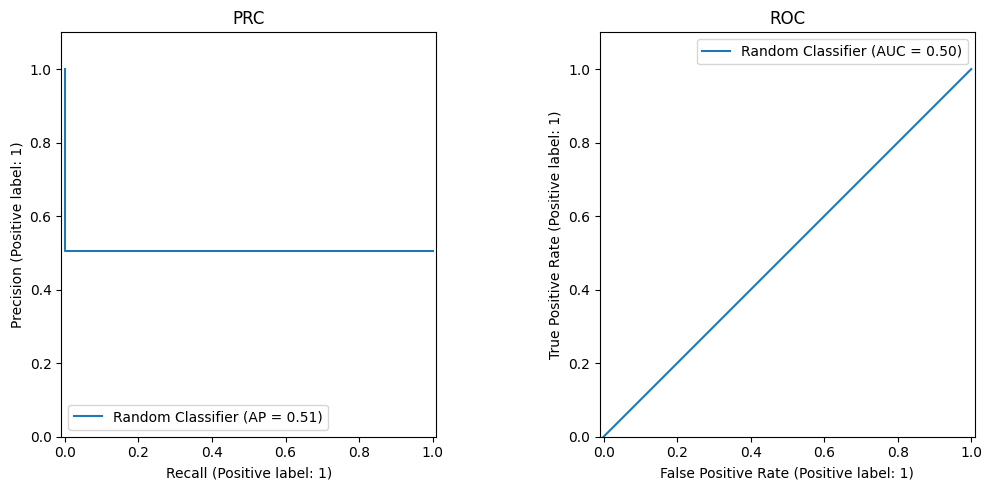

In [81]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [82]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [83]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
log_space = np.logspace(-1, 4, 20)
searcher = GridSearchCV(LinearSVC(), [{"C": log_space}],
                        scoring="average_precision", cv=10, n_jobs=-1)
searcher.fit(X_train, y_train)
best_reg = searcher.best_params_["C"]
print(f"Лучший C: {best_reg}")

Лучший C: 0.1


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

SVM metrics
AUC-PR: 0.8152
AUC-ROC: 0.8479


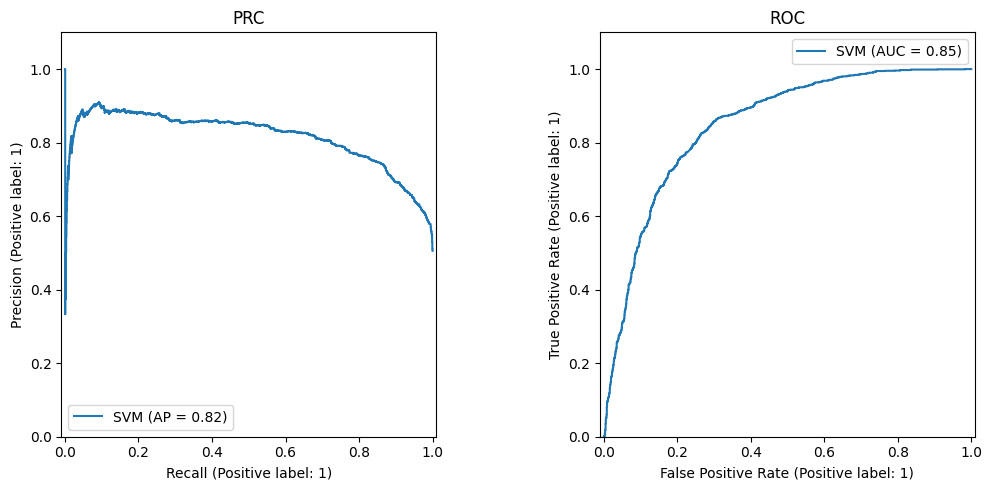

In [84]:
import sklearn.svm as svm
model_svm = svm.SVC(C=best_reg, kernel='linear', probability=True).fit(X_train, y_train)
prob = model_svm.predict_proba(X_test)[:,1]
depict_pr_roc(y_test, prob, 'SVM')

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали? --  при увеличении порога у нас лучше будут делиться классы, но сама точность этих разделений очевидно будет страдать. Плотность будеь меньше, а точность больше.
- Монотонные ли кривые? Как вы это объясните? -- PRC нет, а ROC да. Ну просто у рок кривой параметры (фпр и прочее) имеют общие параметры, поэтому изменение порога влияет на них одинаково, а в первом случае точность зависит от верно предсказанных к общему положительно предсказанным поэтому его может колбасить.

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000

У МЕНЯ:
SVM metrics
AUC-PR: 0.8152
AUC-ROC: 0.8479

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [86]:
from sklearn.linear_model import LogisticRegression
log_space = np.logspace(-1, 4, 20)

searcher = GridSearchCV(LogisticRegression(penalty='l2', solver='liblinear'), 
                        [{"C": log_space}], 
                        scoring="average_precision", 
                        cv=10, 
                        n_jobs=-1)
searcher.fit(X_train, y_train)
best_reg = searcher.best_params_["C"]
print(f"Лучший C: {best_reg}")

Лучший C: 23.357214690901213


Logistic Regression metrics
AUC-PR: 0.8294
AUC-ROC: 0.8479


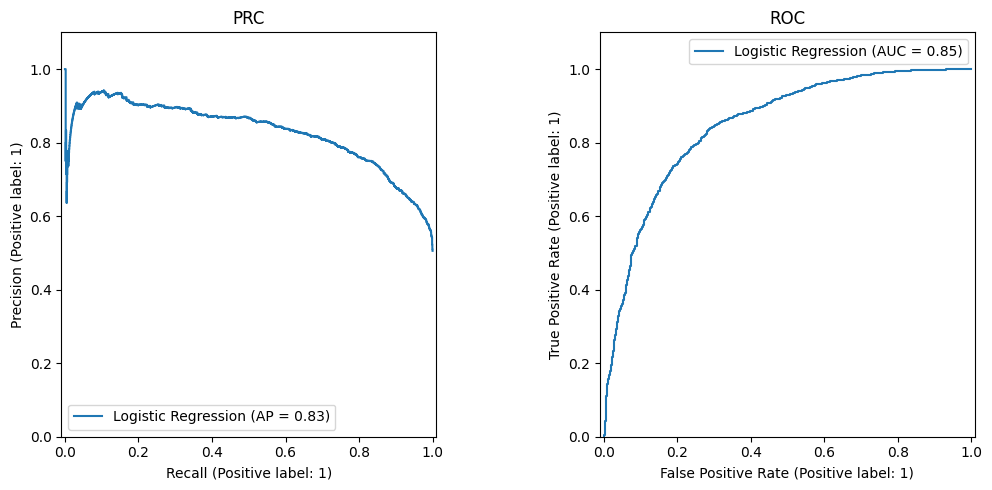

In [87]:
model_log = LogisticRegression(C=best_reg).fit(X_train, y_train)
probs_log = model_log.predict_proba(X_test)[:,1]
depict_pr_roc(y_test, probs_log, 'Logistic Regression')

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

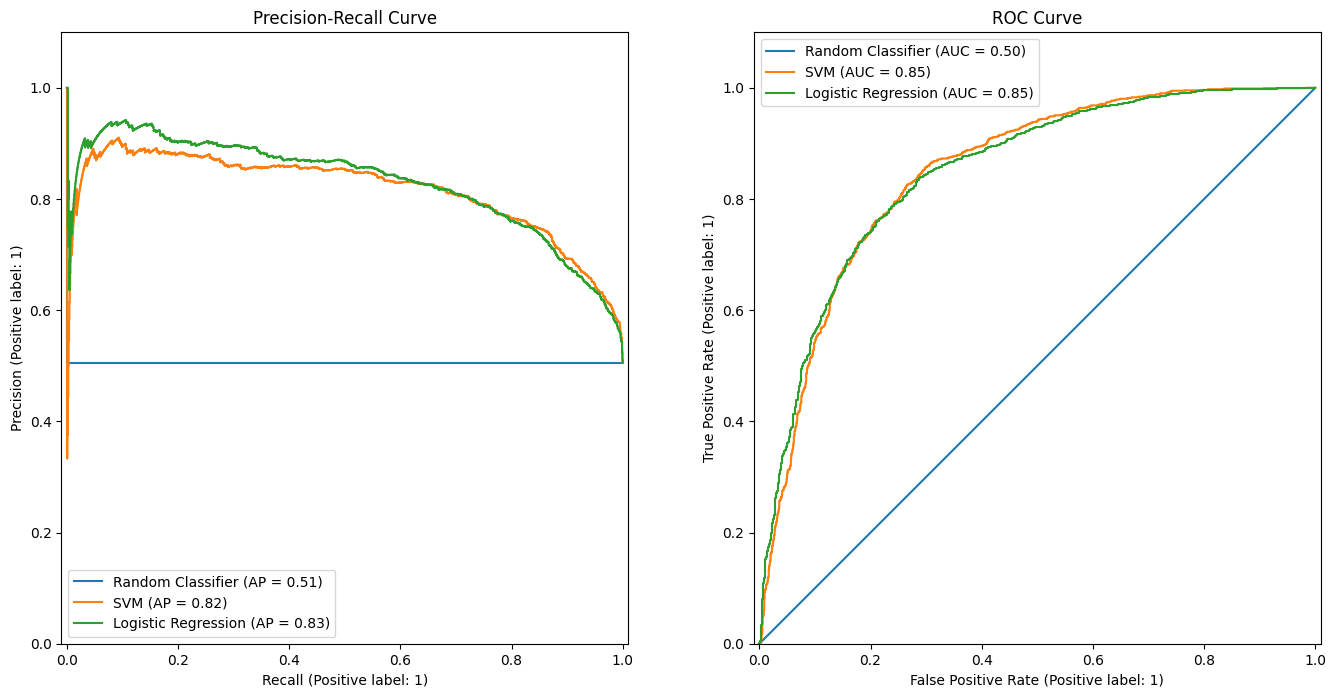

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0], name='Random Classifier')
RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1], name='Random Classifier')
PrecisionRecallDisplay.from_predictions(y_test, prob, ax=ax[0], name='SVM')
RocCurveDisplay.from_predictions(y_test, prob, ax=ax[1], name='SVM')
PrecisionRecallDisplay.from_predictions(y_test, probs_log, ax=ax[0], name='Logistic Regression')
RocCurveDisplay.from_predictions(y_test, probs_log, ax=ax[1], name='Logistic Regression')

ax[0].set_title("Precision-Recall Curve")
ax[1].set_title("ROC Curve")
ax[0].set_ylim(0, 1.1)
ax[1].set_ylim(0, 1.1)
plt.tight_layout()
plt.legend()
plt.show()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** или я даун или ну очень близко друг к другу получились показатели. Подозреваю что можно было бы поиграться со штрафами логрега, но этого и не просят, так что ответ -- они схожи очень, но на пр логрег показал себя чуточку лучше.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [89]:
# your code here
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)
model = svm.SVC(kernel='linear', probability=True).fit(X, y)

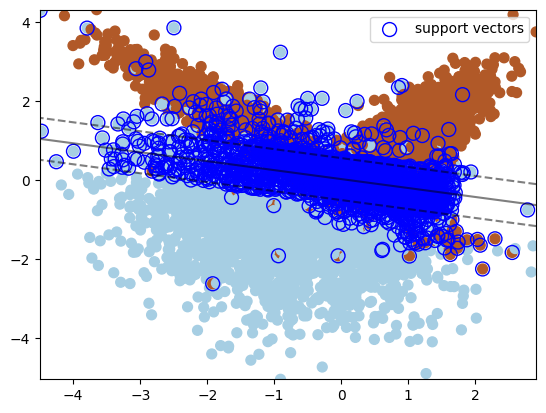

In [90]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(
        X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=50
    )

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(
            model.support_vectors_[:, 0], model.support_vectors_[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?
**ОТВЕТ::** которые лежат рядом с пунктирной линией (зазор) и внутри нее, но до гиперплоскости. Идейно опорными векторами тут являются объекты из двух классов, которые концетрируются каждая у своей стороны, чтобы гиперплоскость разделила наши данные. Но бтв тут заметно что значение зазора маленькое (мягкий зазор) ибо границы нарушаются (которые опорные вектора и задают в совокупе с зазором).

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

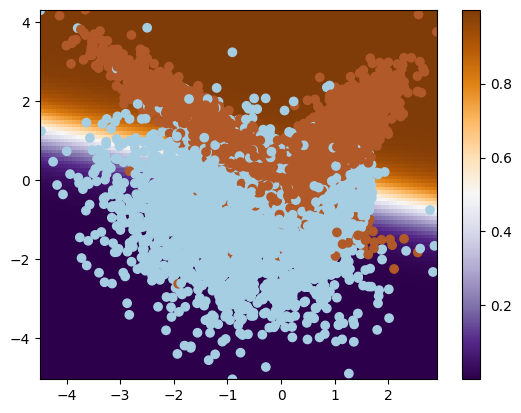

In [91]:
model = LogisticRegression()
model.fit(X, y)


def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(
        X[:, 0], X[:, 1], c=y,
        cmap=plt.cm.Paired
    )

    plt.colorbar(image)

plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Никак там как будто нет никаких кружков (т.е. не относит себя ни к какому классу).

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [92]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l+ r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [93]:
from sklearn.svm import SVC

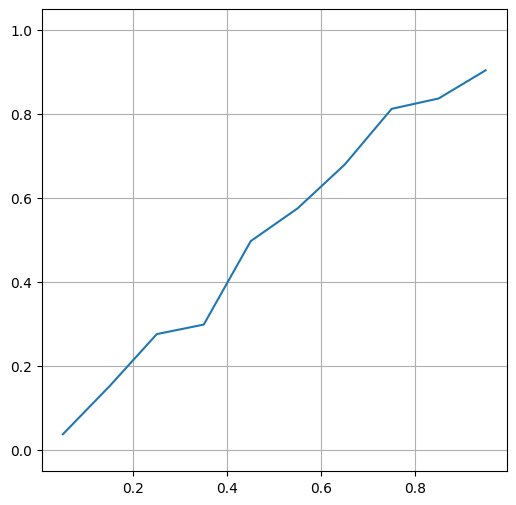

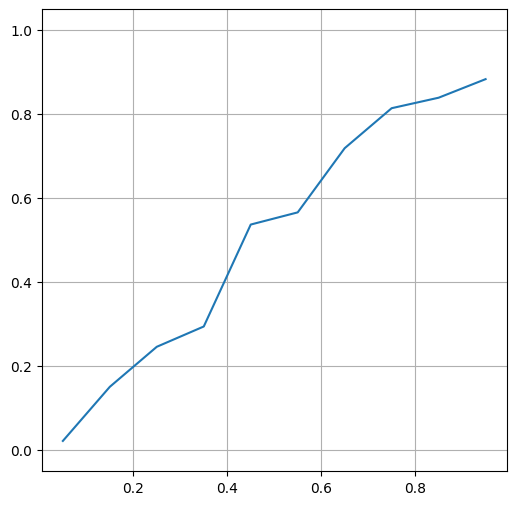

In [ ]:
# your code here
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict_proba(X_test)[:,1]

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict_proba(X_test)[:,1]

plot_calibration_curve(y_test, y_pred_logreg)
plot_calibration_curve(y_test, y_pred_svm)

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** норм, ну она близка к диаганальной(тип у=х) что является показателем идеальной калибровки (ну очев если бы вышло прям y=x значит либо модель оч простая либо код гавно). в нашем случае она не идеально прямая но идет, я бы с осторожкой смотрел на такие резы.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [ ]:
from sklearn.metrics import log_loss, brier_score_loss

logloss_svm = log_loss(y_test, y_pred_svm)
logloss_logreg = log_loss(y_test, y_pred_logreg)

brier_svm = brier_score_loss(y_test, y_pred_svm)
brier_logreg = brier_score_loss(y_test, y_pred_logreg)

print(f"SVM LogLoss: {logloss_svm:.4f}")
print(f"Logistic Regression LogLoss: {logloss_logreg:.4f}")
print(f"SVM BrierScore: {brier_svm:.4f}")
print(f"Logistic Regression BrierScore: {brier_logreg:.4f}")

SVM LogLoss: 0.4873
Logistic Regression LogLoss: 0.4859
SVM BrierScore: 0.1581
Logistic Regression BrierScore: 0.1586


Изучите распределение ответов классификаторов при помощи гистограмм

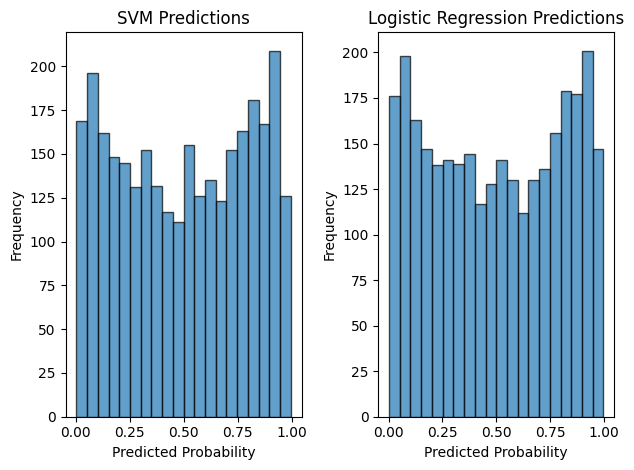

In [96]:

plt.subplot(1, 2, 1)
plt.hist(y_pred_svm, bins=20, edgecolor='k', alpha=0.7)
plt.title('SVM Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(y_pred_logreg, bins=20, edgecolor='k', alpha=0.7)
plt.title('Logistic Regression Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Они похожи, но у свм больше экстрем значений

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

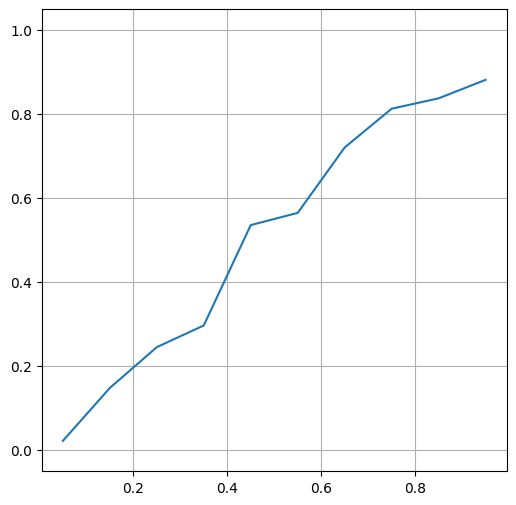

In [97]:
from sklearn.calibration import CalibratedClassifierCV

svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

calibrated_svm = CalibratedClassifierCV(svm, cv="prefit")
calibrated_svm.fit(X, y)
calibrated_preds_svm = calibrated_svm.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, calibrated_preds_svm)

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** net

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
from sklearn.linear_model import LogisticRegression

class PlattScaling:
    def __init__(self, base_estimator): # ну авг инит класса, который принимает на вход базовый классификатор
        self.base_estimator = base_estimator 
        self.platt_model = LogisticRegression()

    def fit(self, X, y): # метод фит, который обучает базовый классификатор и логистическую регрессию на выходе базового классификатора
        self.base_estimator.fit(X, y)
        decision_function = self.base_estimator.decision_function(X)
        self.platt_model.fit(decision_function.reshape(-1, 1), y) # обучаем логистическую регрессию на выходе базового классификатора 

    def predict_proba(self, X): # метод предикт проба, который делает предсказание вероятности с помощью логистической регрессии
        decision_function = self.base_estimator.decision_function(X) # получаем предсказание базового классификатора
        return self.platt_model.predict_proba(decision_function.reshape(-1, 1)) # делаем предсказание вероятности с помощью логистической регрессии

svm = SVC(C=best_reg, kernel='linear', probability=True) # создаем объект классификатора
platt_scaling = PlattScaling(svm) # создаем объект класса платтскейлинг
platt_scaling.fit(X_train, y_train) # обучаем платтскейлинг на тренировочной выборке
calibrated_preds_svm = platt_scaling.predict_proba(X_test)[:, 1] # делаем предсказание вероятности на тестовой выборке

plot_calibration_curve(y_test, calibrated_preds_svm)

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [ ]:
%pip install kagglehub


   ---------------------------------------- 0.0/43.0 kB ? eta -:--:--
   ---------------------------------------- 43.0/43.0 kB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:

import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

100%|██████████| 22.2k/22.2k [00:00<00:00, 355kB/s]

Extracting files...


In [ ]:
df = pd.read_csv(path)
df.fillna('undefined', inplace=True)

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

X_numerical = df[['Income', 'Children', 'Cars', 'Age']]
X_categorical = df[['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']]
X_categorical = X_categorical.astype(str)

C:\Users\1\AppData\Local\Temp\ipykernel_2124\787149402.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'undefined' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('undefined', inplace=True)


В начале поработаем только с категориальными признаками

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import time

start_time = time.time()

ordinal_encoder = OrdinalEncoder()
X_train_encoded = ordinal_encoder.fit_transform(X_train)
X_test_encoded = ordinal_encoder.transform(X_test)

logistic_regression_model = LogisticRegression(max_iter=1000, random_state=777)
logistic_regression_model.fit(X_train_encoded, y_train)

end_time = time.time()

predicted_probabilities = logistic_regression_model.predict_proba(X_test_encoded)[:, 1]

auc_pr_score = average_precision_score(y_test, predicted_probabilities)

print(f"Время выполнения: {end_time - start_time:.2f} секунд")
print(f"AUC-PR: {auc_pr_score:.4f}")

Время выполнения: 0.01 секунд
AUC-PR: 0.5887


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

start_time = time.time()

ordinal_encoder = OneHotEncoder()
X_train_encoded = ordinal_encoder.fit_transform(X_train)
X_test_encoded = ordinal_encoder.transform(X_test)

logistic_regression_model = LogisticRegression(max_iter=1000, random_state=777)
logistic_regression_model.fit(X_train_encoded, y_train)

end_time = time.time()

predicted_probabilities = logistic_regression_model.predict_proba(X_test_encoded)[:, 1]

auc_pr_score = average_precision_score(y_test, predicted_probabilities)

print("Сравнение OrdinalEncoder и OneHotEncoder")
print("---------------------------------------------")
print("OrdinalEncoder")
print(f"Время выполнения: {end_time - start_time:.2f} секунд")
print(f"AUC-PR: {auc_pr_score:.4f}")
print("---------------------------------------------")
print("OneHotEncoder")
print(f"Время выполнения: {end_time - start_time:.2f} секунд")
print(f"AUC-PR: {auc_pr_score:.4f}")

Сравнение OrdinalEncoder и OneHotEncoder
---------------------------------------------
OrdinalEncoder
Время выполнения: 0.01 секунд
AUC-PR: 0.6663
---------------------------------------------
OneHotEncoder
Время выполнения: 0.01 секунд
AUC-PR: 0.6663


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [ ]:
def mean_target_encoding(X, y, X_test):
    encoded_X = X.copy()
    encoded_X_test = X_test.copy()
    for col in X.columns:
        means = y.groupby(X[col]).mean()
        encoded_X[col] = X[col].map(means)
        encoded_X_test[col] = X_test[col].map(means)
    return encoded_X, encoded_X_test

start_time = time.time()

X_train_encoded, X_test_encoded = mean_target_encoding(X_train, y_train, X_test)

logistic_regression_model = LogisticRegression(max_iter=1000, random_state=777)
logistic_regression_model.fit(X_train_encoded, y_train)

end_time = time.time()

predicted_probabilities = logistic_regression_model.predict_proba(X_test_encoded)[:, 1]

auc_pr_score = average_precision_score(y_test, predicted_probabilities)
print("Сравнение OrdinalEncoder и OneHotEncoder и MeanTargetEncoder")
print("---------------------------------------------")
print("OrdinalEncoder")
print(f"Время выполнения: {end_time - start_time:.2f} секунд")
print(f"AUC-PR: {auc_pr_score:.4f}")
print("---------------------------------------------")
print("OneHotEncoder")
print(f"Время выполнения: {end_time - start_time:.2f} секунд")
print(f"AUC-PR: {auc_pr_score:.4f}")
print("---------------------------------------------")
print("MeanTargetEncoder")
print(f"Время выполнения: {end_time - start_time:.2f} секунд")
print(f"AUC-PR: {auc_pr_score:.4f}")

Сравнение OrdinalEncoder и OneHotEncoder и MeanTargetEncoder
---------------------------------------------
OrdinalEncoder
Время выполнения: 0.01 секунд
AUC-PR: 0.6575
---------------------------------------------
OneHotEncoder
Время выполнения: 0.01 секунд
AUC-PR: 0.6575
---------------------------------------------
MeanTargetEncoder
Время выполнения: 0.01 секунд
AUC-PR: 0.6575


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.global_mean = None
        self.category_means = {}

    def fit(self, X, y):
        self.global_mean = y.mean()
        for feature in self.categorical_features:
            self.category_means[feature] = y.groupby(X[feature]).mean()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.categorical_features:
            X_transformed[feature] = X[feature].map(self.category_means[feature]).fillna(self.global_mean)
        return X_transformed

categorical_features = X_categorical.columns.tolist()
mean_target_encoder = MeanTargetEncoder(categorical_features=categorical_features)

mean_target_encoder.fit(X_train, y_train)

X_train_encoded = mean_target_encoder.transform(X_train)
X_test_encoded = mean_target_encoder.transform(X_test)

logistic_regression_model = LogisticRegression(max_iter=1000, random_state=777)
logistic_regression_model.fit(X_train_encoded, y_train)

predicted_probabilities = logistic_regression_model.predict_proba(X_test_encoded)[:, 1]

auc_pr_score = average_precision_score(y_test, predicted_probabilities)
print(f"AUC-PR: {auc_pr_score:.4f}")

AUC-PR: 0.6575


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [ ]:
class MeanTargetEncoderWithNoise(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, noise_level=0.01):
        self.categorical_features = categorical_features
        self.global_mean = None
        self.category_means = {}
        self.noise_level = noise_level

    def fit(self, X, y):
        self.global_mean = y.mean()
        for feature in self.categorical_features:
            means = y.groupby(X[feature]).mean()
            noise = np.random.normal(0, self.noise_level, size=means.shape)
            self.category_means[feature] = means + noise
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.categorical_features:
            X_transformed[feature] = X[feature].map(self.category_means[feature]).fillna(self.global_mean)
        return X_transformed

start_time = time.time()

mean_target_encoder_with_noise = MeanTargetEncoderWithNoise(categorical_features=X_categorical.columns.tolist(), noise_level=0.01)
mean_target_encoder_with_noise.fit(X_train, y_train)

X_train_encoded = mean_target_encoder_with_noise.transform(X_train)
X_test_encoded = mean_target_encoder_with_noise.transform(X_test)

logistic_regression_model = LogisticRegression(max_iter=1000, random_state=777)
logistic_regression_model.fit(X_train_encoded, y_train)

end_time = time.time()

predicted_probabilities = logistic_regression_model.predict_proba(X_test_encoded)[:, 1]

auc_pr_score = average_precision_score(y_test, predicted_probabilities)

print(f"Время выполнения: {end_time - start_time:.2f} секунд")
print(f"AUC-PR: {auc_pr_score:.4f}")

Время выполнения: 0.01 секунд
AUC-PR: 0.6650


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** ага. помогло но гига чуток


##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
from sklearn.model_selection import KFold

class MeanTargetEncoderCV(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, n_splits=5, noise_level=0.01):
        self.categorical_features = categorical_features
        self.global_mean = None
        self.n_splits = n_splits
        self.noise_level = noise_level
        self.category_means = {}

    def fit(self, X, y):
        self.global_mean = y.mean()
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)

        for feature in self.categorical_features:
            self.category_means[feature] = {}
            for train_idx, val_idx in kf.split(X):
                train_X, val_X = X.iloc[train_idx], X.iloc[val_idx]
                train_y = y.iloc[train_idx]
                means = train_y.groupby(train_X[feature]).mean()
                noise = np.random.normal(0, self.noise_level, size=means.shape)
                means += noise
                self.category_means[feature].update(means.to_dict())
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.categorical_features:
            X_transformed[feature] = X[feature].map(self.category_means[feature]).fillna(self.global_mean)
        return X_transformed


start_time = time.time()

mean_target_encoder_cv = MeanTargetEncoderCV(categorical_features=X_categorical.columns.tolist(), n_splits=5, noise_level=0.01)
mean_target_encoder_cv.fit(X_train, y_train)

X_train_encoded = mean_target_encoder_cv.transform(X_train)
X_test_encoded = mean_target_encoder_cv.transform(X_test)

logistic_regression_model = LogisticRegression(max_iter=1000, random_state=777)
logistic_regression_model.fit(X_train_encoded, y_train)

end_time = time.time()

predicted_probabilities = logistic_regression_model.predict_proba(X_test_encoded)[:, 1]

auc_pr_score = average_precision_score(y_test, predicted_probabilities)

print(f"Время выполнения: {end_time - start_time:.2f} секунд")
print(f"AUC-PR: {auc_pr_score:.4f}")

Время выполнения: 0.04 секунд
AUC-PR: 0.6692


#### __Задание 7. Сглаживание счетчиков__  (1 балл)

Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \cdot \text{global\_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$

где $\text{global\_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше, и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding. 


In [ ]:
class MeanTargetEncoderWithSmoothing(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, C=10):
        self.categorical_features = categorical_features
        self.global_mean = None
        self.category_means = {}
        self.C = C

    def fit(self, X, y):
        self.global_mean = y.mean()
        for feature in self.categorical_features:
            category_means = y.groupby(X[feature]).mean()
            category_counts = X[feature].value_counts()
            smoothed_means = (category_means * category_counts + self.C * self.global_mean) / (category_counts + self.C)
            self.category_means[feature] = smoothed_means
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.categorical_features:
            X_transformed[feature] = X[feature].map(self.category_means[feature]).fillna(self.global_mean)
        return X_transformed


start_time = time.time()

encoder = MeanTargetEncoderWithSmoothing(categorical_features=X_categorical.columns.tolist(), C=10)
encoder.fit(X_train, y_train)

X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

logistic_regression_model = LogisticRegression(max_iter=1000, random_state=777)
logistic_regression_model.fit(X_train_encoded, y_train)

end_time = time.time()

predicted_probabilities = logistic_regression_model.predict_proba(X_test_encoded)[:, 1]

auc_pr_score = average_precision_score(y_test, predicted_probabilities)

print(f"Время выполнения: {end_time - start_time:.2f} секунд")
print(f"AUC-PR: {auc_pr_score:.4f}")

Время выполнения: 0.02 секунд
AUC-PR: 0.6713


при с=10 рез и так лучше по сравнению с OHE

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [ ]:
X_numerical = X_numerical.apply(pd.to_numeric, errors='coerce') # проверка на числовые значения 

X_numerical = X_numerical.fillna(X_numerical.median())

X_train_combined = pd.concat([X_train_encoded.reset_index(drop=True), X_numerical.loc[X_train.index].reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([X_test_encoded.reset_index(drop=True), X_numerical.loc[X_test.index].reset_index(drop=True)], axis=1)

logistic_regression_model = LogisticRegression(max_iter=1000, random_state=777)
logistic_regression_model.fit(X_train_combined, y_train)

predicted_probabilities = logistic_regression_model.predict_proba(X_test_combined)[:, 1]
auc_pr_score = average_precision_score(y_test, predicted_probabilities)

print(f"AUC-PR with combined features: {auc_pr_score:.4f}")

AUC-PR with combined features: 0.6881


 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [ ]:
unique_values = X_numerical.nunique()
print("Unique values in numerical features:")
print(unique_values)

encoder = MeanTargetEncoderWithSmoothing(categorical_features=X_numerical.columns.tolist(), C=10)
encoder.fit(X_numerical.loc[X_train.index], y_train)

X_train_num_encoded = encoder.transform(X_numerical.loc[X_train.index])
X_test_num_encoded = encoder.transform(X_numerical.loc[X_test.index])

X_train_combined = pd.concat([X_train_encoded.reset_index(drop=True), X_train_num_encoded.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([X_test_encoded.reset_index(drop=True), X_test_num_encoded.reset_index(drop=True)], axis=1)

logistic_regression_model = LogisticRegression(max_iter=1000, random_state=777)
logistic_regression_model.fit(X_train_combined, y_train)

predicted_probabilities = logistic_regression_model.predict_proba(X_test_combined)[:, 1]
auc_pr_score = average_precision_score(y_test, predicted_probabilities)

print(f"AUC-PR with combined features: {auc_pr_score:.4f}")

Unique values in numerical features:
Income      16
Children     6
Cars         5
Age         53
dtype: int64
AUC-PR with combined features: 0.6714


**ОТВЕТЫ:** ЧУТОк лучше стало, да

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ # счетчики они компактные (в плане можно много признаков хоть на 1 заменить) + учитывает инфу про целевую переменную (ну как бы при правильном подборе параметров мы можем избежать переобучения, так еще и добиться лучше качества). по поводу минусов - очев учетка, надо возиться с категориями которые редко встречаются. Оверолл минусы очев есть, но при правильной работе в задаче реальной жизни как будто счетчик сильно предпочтительнее.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [ ]:
import requests

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
response = requests.get(url)

with open("adult.data", "wb") as file:
    file.write(response.content)



In [101]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
19674,33,Private,243674,HS-grad,9,Separated,Tech-support,Not-in-family,White,Male,0,0,46,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [102]:
# your code here
y = df['income']
X = df.drop(columns=['income'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [ ]:
from sklearn.compose import ColumnTransformer

categorical_features = ["workclass", "education", "marital-status", "occupation", "relationship", 
                        "race", "sex","native-country"]
numeric_features = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ])
preprocessor.fit(X_train)
X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)
print(f"Количество новых признаков: {X_train_encoded.shape[1]}")

Количество новых признаков: 94


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [112]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=777))
])

pipeline.fit(X_train, y_train)

predicted_probabilities = pipeline.predict_proba(X_test)[:, 1]

auc_pr_score = average_precision_score(y_test, predicted_probabilities)

print(f"AUC-PR: {auc_pr_score:.4f}")

AUC-PR: 0.7335


c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [114]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.25, random_state=777, stratify=y_train
)

print(f"Размер обучающей выборкe-{X_train_split.shape}")
print(f"Размер валидац выборки- {X_val_split.shape}")

Размер обучающей выборкe-(18315, 14)
Размер валидац выборки- (6105, 14)


Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [ ]:
model = pipeline.named_steps["classifier"]
coef_abs = np.abs(model.coef_[0])
top_40_indices = np.argsort(coef_abs)[-40:]
X_train_top_40 = pipeline.named_steps["preprocessor"].transform(X_train_split)[:, top_40_indices]
X_val_top_40 = pipeline.named_steps["preprocessor"].transform(X_val_split)[:, top_40_indices]

model_top_40 = LogisticRegression(max_iter=1000, random_state=777)
model_top_40.fit(X_train_top_40, y_train_split)

predicted_probabilities_top_40 = model_top_40.predict_proba(X_val_top_40)[:, 1]

auc_pr_score_top_40 = average_precision_score(y_val_split, predicted_probabilities_top_40)

end_time = time.time()

print(f"Время выполнения: {end_time - start_time:.2f} секунд")
print(f"AUC-PR с топ-40 признаками: {auc_pr_score_top_40:.4f}")

Время выполнения: 8.95 секунд
AUC-PR с топ-40 признаками: 0.6735


Изменилось ли качество? Как? -- ухудшилось 

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось? Получился топчик, аук увеличился.


In [122]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ])

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=777))
])

pipeline.fit(X_train, y_train)

predicted_probabilities = pipeline.predict_proba(X_test)[:, 1]

auc_pr_score = average_precision_score(y_test, predicted_probabilities)
print(f"AUC-PR with all features: {auc_pr_score:.4f}")

model = pipeline.named_steps["classifier"]
selector = SelectFromModel(model, prefit=True, max_features=40)
X_train_top_40 = selector.transform(pipeline.named_steps["preprocessor"].transform(X_train_split))
X_val_top_40 = selector.transform(pipeline.named_steps["preprocessor"].transform(X_val_split))

model_top_40 = LogisticRegression(max_iter=1000, random_state=777)
model_top_40.fit(X_train_top_40, y_train_split)

predicted_probabilities_top_40 = model_top_40.predict_proba(X_val_top_40)[:, 1]

auc_pr_score_top_40 = average_precision_score(y_val_split, predicted_probabilities_top_40)
print(f"AUC-PR with top 40 features: {auc_pr_score_top_40:.4f}")

AUC-PR with all features: 0.7672
AUC-PR with top 40 features: 0.7326


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [123]:

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", Pipeline(steps=[
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
            ("scaler", StandardScaler(with_mean=False))
        ]), categorical_features)
    ])

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=777))
])

pipeline.fit(X_train_split, y_train_split)

model = pipeline.named_steps["classifier"]
selector = SelectFromModel(model, prefit=True, max_features=40)
X_train_top_40 = selector.transform(pipeline.named_steps["preprocessor"].transform(X_train_split))
X_val_top_40 = selector.transform(pipeline.named_steps["preprocessor"].transform(X_val_split))

model_top_40 = LogisticRegression(max_iter=1000, random_state=777)
model_top_40.fit(X_train_top_40, y_train_split)

predicted_probabilities_top_40 = model_top_40.predict_proba(X_val_top_40)[:, 1]

auc_pr_score_top_40 = average_precision_score(y_val_split, predicted_probabilities_top_40)

print(f"AUC-PR with top 40 features after scaling: {auc_pr_score_top_40:.4f}")

new_top_40_indices = selector.get_support(indices=True)
print(f"Selected feature indices: {new_top_40_indices}")
print(f"Selected features changed: {not np.array_equal(top_40_indices, new_top_40_indices)}")

AUC-PR with top 40 features after scaling: 0.7557
Selected feature indices: [  0   2   3   4   5  12  16  26  28  31  33  35  36  42  43  46  47  53
  54  56  58  61  63  64  92 105]
Selected features changed: True


Если честно я не выкупил прикол зачем это делать, но да качество увеличилось

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** корреляция показывает линейную зависимость между признаком и цел перемен (чем выше кор тем больше зависимость). Я бы использовал чтобы отбирать признаки с высокой корр, убрал бы с низкой оч (тип шум у которых корр 0), подумал бы что делать именно с признакми которые корр между собой сильно.

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [ ]:
df_encoded = pd.get_dummies(df.drop(columns=['income']), drop_first=True)
df_encoded['income'] = df['income']

correlations = df_encoded.corr()['income'].abs().sort_values(ascending=False)

top_40_features = correlations.index[1:41] 
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    df_encoded[top_40_features], df_encoded['income'], test_size=0.25, random_state=777, stratify=df_encoded['income']
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val_split)

start_time = time.time()
model = LogisticRegression(max_iter=1000, random_state=777)
model.fit(X_train_scaled, y_train_split)
end_time = time.time()

predicted_probabilities = model.predict_proba(X_val_scaled)[:, 1]
auc_pr_score = average_precision_score(y_val_split, predicted_probabilities)

print(f"Время выполнения: {end_time - start_time:.2f} секунд")
print(f"AUC-PR с топ-40 признаками: {auc_pr_score:.4f}")

Время выполнения: 0.06 секунд
AUC-PR с топ-40 признаками: 0.7628


В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [126]:
def compute_t_statistic(X, y):
    t_stats = []
    for col in X.columns:
        mu_plus = X[y == 1][col].mean()
        mu_minus = X[y == 0][col].mean()
        sigma_plus = X[y == 1][col].std()
        sigma_minus = X[y == 0][col].std()
        n_plus = X[y == 1][col].count()
        n_minus = X[y == 0][col].count()
        t_stat = np.abs(mu_plus - mu_minus) / np.sqrt((n_plus * sigma_plus**2 + n_minus * sigma_minus**2) / (n_plus + n_minus))
        t_stats.append(t_stat)
    return np.array(t_stats)

start_time = time.time()

t_stats = compute_t_statistic(df_encoded.drop(columns=['income']), df_encoded['income'])
top_40_indices = np.argsort(t_stats)[-40:]
top_40_features = df_encoded.columns[top_40_indices]

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    df_encoded[top_40_features], df_encoded['income'], test_size=0.25, random_state=777, stratify=df_encoded['income']
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val_split)

model = LogisticRegression(max_iter=1000, random_state=777)
model.fit(X_train_scaled, y_train_split)

end_time = time.time()

predicted_probabilities = model.predict_proba(X_val_scaled)[:, 1]
auc_pr_score = average_precision_score(y_val_split, predicted_probabilities)

print(f"Время выполнения: {end_time - start_time:.2f} секунд")
print(f"AUC-PR с топ-40 признаками: {auc_pr_score:.4f}")

Время выполнения: 1.33 секунд
AUC-PR с топ-40 признаками: 0.7628


#### __Задание 11. Методы-обёртки__ (1 балл) 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

я тут навернео перемудрил..

In [156]:
available_numerical_features = [col for col in numeric_features if col in X_train_split.columns]
available_categorical_features = [col for col in categorical_features if col in X_train_split.columns]

def wrapper_feature_selection(X_train, y_train, X_val, y_val, k=40, m=5):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), available_numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), available_categorical_features)
        ]
    )
    X_train = preprocessor.fit_transform(X_train)
    X_val = preprocessor.transform(X_val)

    remaining_features = list(range(X_train.shape[1])) 
    best_features = remaining_features.copy()
    best_score = 0

    while len(remaining_features) > k:
        scores = []
        for i in range(0, len(remaining_features), m):
            features_to_remove = remaining_features[i:i + m]
            selected_features = [f for f in remaining_features if f not in features_to_remove]
            model = LogisticRegression(max_iter=1000, random_state=777)
            model.fit(X_train[:, selected_features], y_train)
            predicted_probabilities = model.predict_proba(X_val[:, selected_features])[:, 1]
            score = average_precision_score(y_val, predicted_probabilities)
            scores.append((score, features_to_remove))

        scores.sort(reverse=True, key=lambda x: x[0])
        best_score, features_to_remove = scores[0]
        remaining_features = [f for f in remaining_features if f not in features_to_remove]

        print(f"Remaining features: {len(remaining_features)}, Best score: {best_score:.4f}")

    return remaining_features, best_score

start_time = time.time()

selected_features, best_score = wrapper_feature_selection(X_train_split, y_train_split, X_val_split, y_val_split, k=40, m=5)

end_time = time.time()

print(f"Selected features: {selected_features}")
print(f"Best score: {best_score:.4f}")
print(f"Time taken: {end_time - start_time:.2f} seconds")

model = LogisticRegression(max_iter=1000, random_state=777)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), available_numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), available_categorical_features)
    ]
)
X_train_transformed = preprocessor.fit_transform(X_train_split)
X_test_transformed = preprocessor.transform(X_test)

X_train_selected = X_train_transformed[:, selected_features]
X_test_selected = X_test_transformed[:, selected_features]

model.fit(X_train_selected, y_train_split)
predicted_probabilities = model.predict_proba(X_test_selected)[:, 1]
auc_pr_score = average_precision_score(y_test, predicted_probabilities)

print(f"AUC-PR on test set: {auc_pr_score:.4f}")


Selected features: [0, 1, 2, 3, 4]
Best score: 0.0000
Time taken: 0.01 seconds
AUC-PR on test set: 0.6485


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
def wrapper_feature_selection_add(X_train, y_train, X_val, y_val, k=40):
    remaining_features = list(X_train.columns)
    selected_features = []
    best_score = 0
    while len(selected_features) < k:
        scores = []
        for feature in remaining_features:
            current_features = selected_features + [feature]
            model = LogisticRegression(max_iter=1000, random_state=777)
            model.fit(X_train[current_features], y_train)
            predicted_probabilities = model.predict_proba(X_val[current_features])[:, 1]
            score = average_precision_score(y_val, predicted_probabilities)
            scores.append((score, feature))
        scores.sort(reverse=True, key=lambda x: x[0])
        best_score, best_feature = scores[0]
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        print(f"Selected features: {len(selected_features)}, Best score: {best_score:.4f}")
    return selected_features, best_score

start_time = time.time()

selected_features, best_score = wrapper_feature_selection_add(X_train_split, y_train_split, X_val_split, y_val_split, k=40)

end_time = time.time()

print(f"Selected features: {selected_features}")
print(f"Best score: {best_score:.4f}")
print(f"Time taken: {end_time - start_time:.2f} seconds")

model = LogisticRegression(max_iter=1000, random_state=777)
model.fit(X_train_split[selected_features], y_train_split)
predicted_probabilities = model.predict_proba(X_test[selected_features])[:, 1]
auc_pr_score = average_precision_score(y_test, predicted_probabilities)

print(f"AUC-PR on test set: {auc_pr_score:.4f}")

Да, начиная с 30 качество стало ухудшаться(методом пристального взгляда узнал эту информацию) и лучший там соотвественно значение 0.7624

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** фильтрации: плюсы: Быстрые, простые, не зависят от модели, минусы: Учитывают только статистические зависимости, игнорируют взаимодействие признаков. метод обертки:плюсы: учитывают взаимодействие признаков, высокое качество отбора
минусы: медленные, вычислительно затратные, риск переобучения
встроенные методы:плюсы: интегрированы в процесс обучения модели, эффективны, учитывают взаимодействие.минусы: зависимы от выбранной модели, требуют обучения модели для оценки. Лучший метод - встроенные методы, там около 0.7680

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [158]:
import requests
import zipfile
import io

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
	z.extractall()

df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [159]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [160]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [177]:
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

def cross_validate(
    X,
    y,
    model,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        metric_dict = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred)
        }
        metrics.append(metric_dict)

    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [174]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numerical_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=777))
])

metrics = cross_validate(X, y, pipeline, n_splits=5, random_state=777, shuffle=True)

average_metrics = metrics.mean()
print("Average metrics from cross-validation:")
print(average_metrics)

Average metrics from cross-validation:
accuracy     0.899752
precision    0.660895
recall       0.228031
f1_score     0.338713
dtype: float64


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [176]:
def calculate_profit(y_true, y_pred, call_cost=2, revenue_per_conversion=10):
    positive_predictions = y_pred > 0.5
    true_positives = (positive_predictions & y_true).sum()
    total_call_cost = positive_predictions.sum() * call_cost
    total_revenue = true_positives * revenue_per_conversion
    profit = total_revenue - total_call_cost
    return profit

def cross_validate_profit(X, y, model, n_splits=5, random_state=None, shuffle=False):
    profits = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]

        profit = calculate_profit(y_test, y_pred)
        profits.append(profit)

    return profits

profits = cross_validate_profit(X, y, pipeline, n_splits=5, random_state=777, shuffle=True)

average_profit = np.mean(profits)
std_profit = np.std(profits)

total_calls = np.mean([sum(pipeline.predict_proba(X.iloc[test_index])[:, 1] > 0.5) for _, test_index in KFold(n_splits=5, random_state=777, shuffle=True).split(X)])
total_call_cost = total_calls * 2

print(f"Средняя прибыль: {average_profit:.2f} доларав америки")
print(f"Стандартное отклонение прибыли: {std_profit:.2f} доларав америки")
print(f"Общая стоимость звонков: {total_call_cost:.2f} доларав америки")

average_metrics = metrics.mean()
print("Средние метрики классификации:")
print(average_metrics)

Средняя прибыль: 1474.00 доларав америки
Стандартное отклонение прибыли: 140.95 доларав америки
Общая стоимость звонков: 621.60 доларав америки
Средние метрики классификации:
accuracy     0.899752
precision    0.660895
recall       0.228031
f1_score     0.338713
dtype: float64


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [178]:
def calculate_profit_with_random_revenue(y_true, y_pred, call_cost=2, revenue_min=0, revenue_max=20):
    positive_predictions = y_pred > 0.5
    true_positives = (positive_predictions & y_true).sum()
    total_call_cost = positive_predictions.sum() * call_cost
    total_revenue = true_positives * np.random.uniform(revenue_min, revenue_max, size=true_positives).sum()
    profit = total_revenue - total_call_cost
    return profit

def cross_validate_profit_with_random_revenue(X, y, model, n_splits=5, random_state=None, shuffle=False):
    profits = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]

        profit = calculate_profit_with_random_revenue(y_test, y_pred)
        profits.append(profit)

    return profits

profits_random_revenue = cross_validate_profit_with_random_revenue(X, y, pipeline, n_splits=5, random_state=777, shuffle=True)

average_profit_random_revenue = np.mean(profits_random_revenue)
std_profit_random_revenue = np.std(profits_random_revenue)

total_calls_random_revenue = np.mean([sum(pipeline.predict_proba(X.iloc[test_index])[:, 1] > 0.5) for _, test_index in KFold(n_splits=5, random_state=777, shuffle=True).split(X)])
total_call_cost_random_revenue = total_calls_random_revenue * 2

print(f"Средняя прибыль с учетом случайной выручки: {average_profit_random_revenue:.2f} доларав америки")
print(f"Стандартное отклонение прибыли с учетом случайной выручки: {std_profit_random_revenue:.2f} доларав америки")
print(f"Общая стоимость звонков с учетом случайной выручки: {total_call_cost_random_revenue:.2f} доларав америки")

Средняя прибыль с учетом случайной выручки: 458410.98 доларав америки
Стандартное отклонение прибыли с учетом случайной выручки: 54725.33 доларав америки
Общая стоимость звонков с учетом случайной выручки: 621.60 доларав америки


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

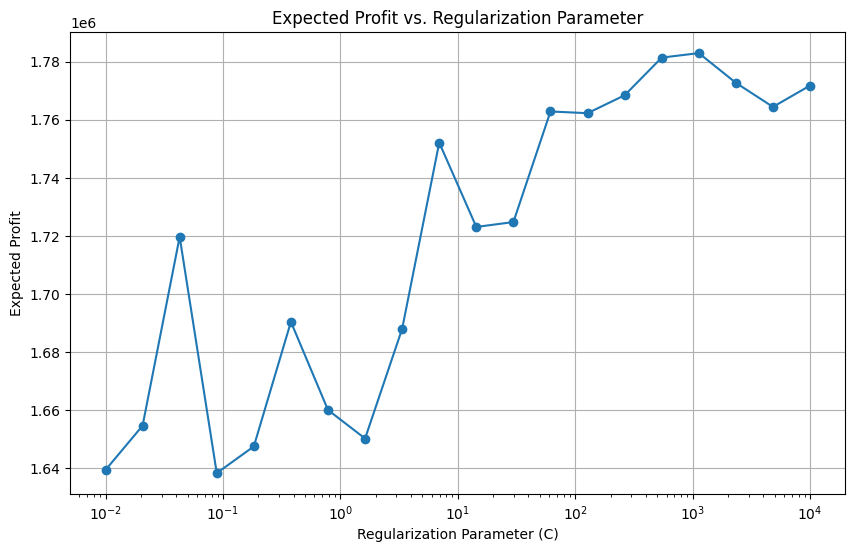

Best regularization parameter: 1128.8378916846884
Maximum expected profit: 1782902.95


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'classifier__C': np.logspace(-2, 4, 20)}

def profit_scorer(estimator, X, y):
    y_pred = estimator.predict_proba(X)[:, 1]
    return calculate_profit_with_random_revenue(y, y_pred)

grid_search = GridSearchCV(pipeline, param_grid, scoring=profit_scorer, cv=5, n_jobs=-1)
grid_search.fit(X, y)

best_reg_param = grid_search.best_params_['classifier__C']
best_profit = grid_search.best_score_
mean_test_scores = grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(10, 6))
plt.plot(param_grid['classifier__C'], mean_test_scores, marker='o')
plt.xscale('log')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Expected Profit')
plt.title('Expected Profit vs. Regularization Parameter')
plt.grid(True)
plt.show()

print(f"Best regularization parameter: {best_reg_param}")
print(f"Maximum expected profit: {best_profit:.2f}")

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Best regularization parameters from multiple runs:
[4832.930238571752, 1128.8378916846884, 263.6650898730355, 14.38449888287663, 1128.8378916846884]
Corresponding profits:
[1806184.0918569625, 1810489.367371418, 1781633.310130934, 1796463.2348182425, 1817075.7002169576]
Unique best regularization parameters: {4832.930238571752, 1128.8378916846884, 14.38449888287663, 263.6650898730355}


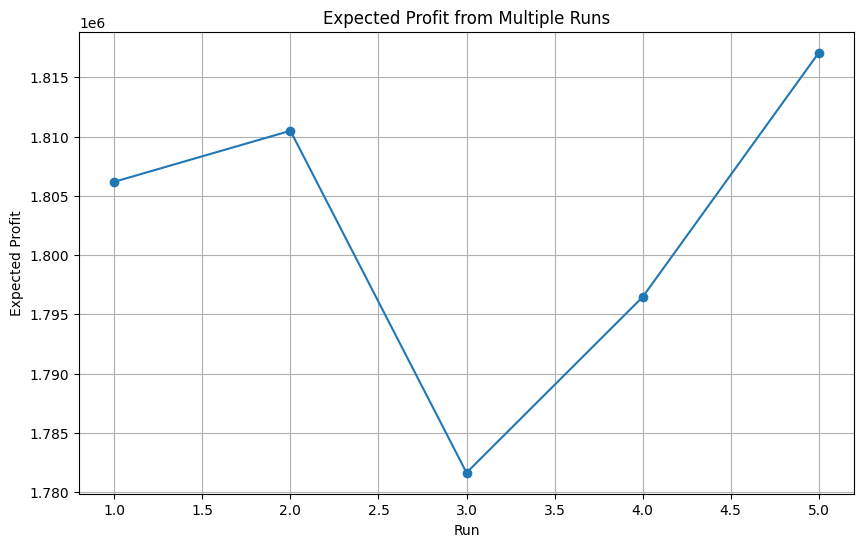

In [180]:
best_params = []
profits = []

for _ in range(5):
    grid_search = GridSearchCV(pipeline, param_grid, scoring=profit_scorer, cv=5, n_jobs=-1)
    grid_search.fit(X, y)
    best_params.append(grid_search.best_params_['classifier__C'])
    profits.append(grid_search.best_score_)

print("Best regularization parameters from multiple runs:")
print(best_params)
print("Corresponding profits:")
print(profits)

unique_best_params = set(best_params)
print(f"Unique best regularization parameters: {unique_best_params}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), profits, marker='o')
plt.xlabel('Run')
plt.ylabel('Expected Profit')
plt.title('Expected Profit from Multiple Runs')
plt.grid(True)
plt.show()

ахахаха, мне кажется я какую то херню пишу, но это лучше чем нечего да и мб тут не такой уж и бред... но тут коэф регуляризации каждый раз разный, зависимоти от параметра и прибыли нет, наоборот она колеблится 

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__  ну презижен показывают долю полож ответов, а рекол измеряют долю реально положит примеров, которые модель предсказала. Есои важно не упустить прибыльного клиента тооо рекол, но если нам дорого обрабатвыать ложные положит резы то лучше презижен. но как моп бизнесмен думаю можно фмеру юзхануть и норм.



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Best threshold: 0.2
Maximum profit: 2794.40


c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

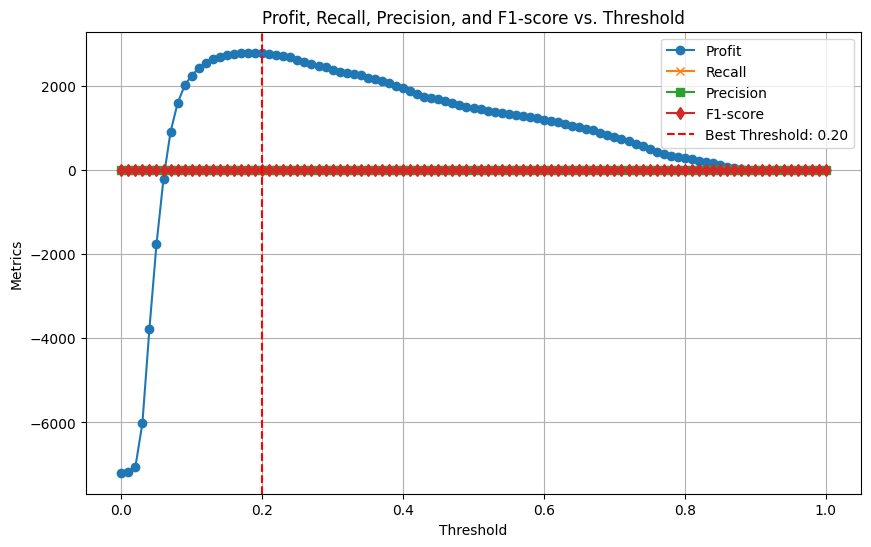

In [184]:
def cross_validate_profit_with_metrics(X, y, model, thresholds, n_splits=5, random_state=None, shuffle=False):
    profits = {threshold: [] for threshold in thresholds}
    recalls = {threshold: [] for threshold in thresholds}
    precisions = {threshold: [] for threshold in thresholds}
    f1_scores = {threshold: [] for threshold in thresholds}
    
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        for threshold in thresholds:
            y_pred = (y_pred_proba >= threshold).astype(int)
            profit = calculate_profit_with_threshold(y_test, y_pred_proba, threshold)
            profits[threshold].append(profit)
            recall = recall_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            recalls[threshold].append(recall)
            precisions[threshold].append(precision)
            f1_scores[threshold].append(f1)

    average_profits = {threshold: np.mean(profit_list) for threshold, profit_list in profits.items()}
    average_recalls = {threshold: np.mean(recall_list) for threshold, recall_list in recalls.items()}
    average_precisions = {threshold: np.mean(precision_list) for threshold, precision_list in precisions.items()}
    average_f1_scores = {threshold: np.mean(f1_list) for threshold, f1_list in f1_scores.items()}
    
    return average_profits, average_recalls, average_precisions, average_f1_scores


thresholds = np.arange(0, 1.01, 0.01)

average_profits, average_recalls, average_precisions, average_f1_scores = cross_validate_profit_with_metrics(
    X, y, pipeline, thresholds, n_splits=5, random_state=777, shuffle=True
)

best_threshold = max(average_profits, key=average_profits.get)
max_profit = average_profits[best_threshold]

print(f"Best threshold: {best_threshold}")
print(f"Maximum profit: {max_profit:.2f}")


plt.figure(figsize=(10, 6))
plt.plot(thresholds, [average_profits[t] for t in thresholds], label="Profit", marker="o")
plt.plot(thresholds, [average_recalls[t] for t in thresholds], label="Recall", marker="x")
plt.plot(thresholds, [average_precisions[t] for t in thresholds], label="Precision", marker="s")
plt.plot(thresholds, [average_f1_scores[t] for t in thresholds], label="F1-score", marker="d")
plt.axvline(best_threshold, color="red", linestyle="--", label=f"Best Threshold: {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Metrics")
plt.title("Profit, Recall, Precision, and F1-score vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()


Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




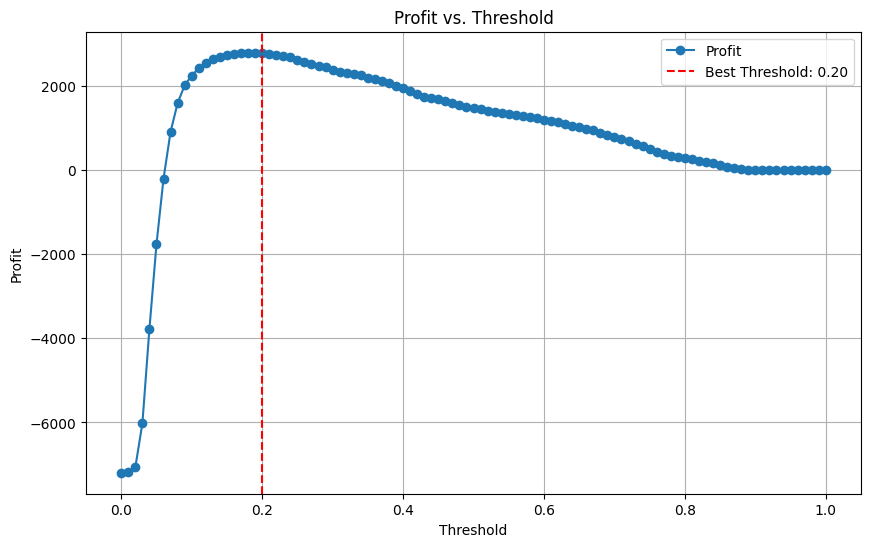

In [185]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, [average_profits[t] for t in thresholds], label="Profit", marker="o")
plt.axvline(best_threshold, color="red", linestyle="--", label=f"Best Threshold: {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Profit")
plt.title("Profit vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области? **ответ:** ну как будто порог находится в не оч месте, наверное много ложных положительных примеров пропустили но по другому не работает, так как мы пытаемся скомпенсировать полноту и точность.

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [186]:
from scipy.stats import ttest_rel

default_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=777))
])

optimized_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C=best_reg_param, max_iter=1000, random_state=777))
])

def cross_validate_profit_with_threshold(X, y, model, threshold, n_splits=5, random_state=None, shuffle=False):
    profits = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)

        profit = calculate_profit(y_test, y_pred)
        profits.append(profit)

    return profits

default_profits = cross_validate_profit_with_threshold(X, y, default_model, threshold=0.5, n_splits=5, random_state=777, shuffle=True)
optimized_profits = cross_validate_profit_with_threshold(X, y, optimized_model, threshold=best_threshold, n_splits=5, random_state=777, shuffle=True)

default_mean_profit = np.mean(default_profits)
default_std_profit = np.std(default_profits)
optimized_mean_profit = np.mean(optimized_profits)
optimized_std_profit = np.std(optimized_profits)

t_stat, p_value = ttest_rel(default_profits, optimized_profits)

print(f"Default model mean profit: {default_mean_profit:.2f}")
print(f"Default model std profit: {default_std_profit:.2f}")
print(f"Optimized model mean profit: {optimized_mean_profit:.2f}")
print(f"Optimized model std profit: {optimized_std_profit:.2f}")
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The difference in profits is statistically significant.")
else:
    print("The difference in profits is not statistically significant.")

Default model mean profit: 1474.00
Default model std profit: 140.95
Optimized model mean profit: 2802.40
Optimized model std profit: 219.56
T-statistic: -19.94
P-value: 0.0000
The difference in profits is statistically significant.


азхахаха, нууу я думаю тут конечно кал, но надеюсь хоть что то за него получу..

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ дубайский шоколад и котлеты